# DSE Course 3 Session 6: Recurrent Neural Networks and Time Series Analysis

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will continue with our wine quality prediction model from Course 1. We will apply strategies to improve our model in light of neural networks. We will display the results of our algorithms using plotly/dash.

<br>

---

<br>

<a name='top'></a>

# Contents

* 6.0 [Preparing Environment and Importing Data](#x.0)
  * 6.0.1 [Import Packages](#x.0.1)
  * 6.0.2 [Load Dataset](#x.0.2)
* 6.1 [Feature Engineering](#x.1)
  * 6.1.1 [Feature Engineering from Course 2](#x.1.1)
* 6.2 [Exploratory Data Analysis with Dash](#x.2)
* 6.3 [Modeling](#x.3)
  * 6.3.1 [Models from Course 1 & 2](#x.3.1)
  * 6.3.2 [Neural Network Model](#x.3.2)
* 6.4 [Model Results with Dash](#x.4)
  

<br>

---

<a name='x.0'></a>

## 6.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 6.0.1 Import Packages

[back to top](#top)

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
from scipy.stats import gamma, norm, expon
from ipywidgets import interact
from statsmodels.tsa.stattools import pacf, acf

<a name='x.0.1'></a>

### 6.0.2 Load Dataset

[back to top](#top)

In [2]:
orders = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
          "ds_for_engineers/main/data/truffle_margin/truffle_orders_noise.csv")
time_cols = ['1/2020', '2/2020', '3/2020', '4/2020',
       '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020',
       '12/2020']
cat_cols = ['Base Cake', 'Truffle Type', 'Primary Flavor', 'Secondary Flavor',
       'Color Group', 'Customer']
orders.columns

Index(['Base Cake', 'Truffle Type', 'Primary Flavor', 'Secondary Flavor',
       'Color Group', 'Customer', '1/2020', '2/2020', '3/2020', '4/2020',
       '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020',
       '12/2020'],
      dtype='object')

In [18]:
orders = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/truffletopia/main/truffletopia/data/12_year_orders.csv")
cat_cols = ['base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor',
       'color_group', 'customer']
time_cols = [i for i in orders.columns if i not in cat_cols]

# note that our data is 'untidy' if we wanted to tidy the data we would need to
# unpivot or 'melt' our date columns like so:
orders.melt(id_vars=cat_cols, var_name='date', value_name='kg')

# however the data as it is, is useful for our purposes of timeseries prediction 
# today

,base_cake,truffle_type,primary_flavor,secondary_flavor,color_group,customer,date,kg
0,Cheese,Candy Outer,Horchata,Vanilla,Amethyst,Perk-a-Cola,1/2010,12570.335165
1,Tiramisu,Chocolate Outer,Irish Cream,Egg Nog,Slate,Dandy's Candies,1/2010,7922.970436
2,Sponge,Chocolate Outer,Ginger Ale,Apple,Slate,Dandy's Candies,1/2010,10521.306722
3,Cheese,Chocolate Outer,Coffee,Pear,Opal,Dandy's Candies,1/2010,4739.122200
4,Chiffon,Jelly Filled,Butter Toffee,Apricot,Olive,Slugworth,1/2010,2756.891961
...,...,...,...,...,...,...,...,...
13195,Chiffon,Chocolate Outer,Acai Berry,Tangerine,Slate,Fickelgruber,12/2020,25714.512372
13196,Butter,Jelly Filled,Plum,Peppermint,Olive,Fickelgruber,12/2020,15043.303525
13197,Chiffon,Chocolate Outer,Wild Cherry Cream,Peppermint,Taupe,Perk-a-Cola,12/2020,8769.613116
13198,Cheese,Candy Outer,Mango,Mango,Rose,Dandy's Candies,12/2020,5065.975534


<a name='x.1'></a>

## 6.1 Why We Think in Sequences

[back to top](#top)

There are some problems that are best framed as a sequence in either the input or the output. For example, in our image classification we are performing a mapping of many to one: sequence input. Other examples include:

* One-to-many: sequence output, e.x. image captions/descriptions
* Many-to-many: seuqence input and output, e.x. machine translation
* Synchronized many-to-many: synced sequence input and output, e.x. video classification

State of the art handling of sequences has occurred in a class of networks called recurrent neural networks

<a name='x.1.1'></a>

## 6.2 Recurrent Neural Networks

[back to top](#top)

Recurrent Neural Networks (RNNs) can be thought of as a FFNN with loops added into the architecture. This allows the network to retain information, create "memory" that can be associated with signals later in the sequence. 

We didn't go into much detail about the actual training of neural networks **_back propagation_** but what we will say here, is that this algorithm breaks down with recurrent neural networks because of the looped connections. A trick was created to overcome this, where the looped connections are unrolled, using a copy of the "unhooked" neuron to represent where the loop was initally fed back. This algorithm is called **_back propagation through time_**.

Another problem is introduced when training recurrent neural networks, in that the gradients calculated during back propagation can become very large, **_exploding gradients_**, or very small **_vanishing gradients_**. This problem is modulated in FNNNs by the ReLU, In RNNs, a more sophisticated gating mechanism is used in an architecture we call **_Long Short-Term Memory Networks_**



### 6.2.1 Long Short-Term Memory Networks

[back to top](#top)

Long Short-Term Memory Networks (LSTMs) are a type of RNN that are trained using back propagation through time and overcome the vanishing/exploding gradient problem. Similar to CNNs, their architecture is composed of blocks, This time with memory blocks rather than convolutional blocks. A block is smarter than the classical neuron; it contains gates that manage the block's state and output. The gates are operated by a sigmoid function, determining whether they are open or closed (triggered or not trigerred). There are three types of gates within a memory block:

* Forget gate: decides what information is discarded
* Input gate: decides what information updates the memory state
* Output gate: decides what information to send forward depending on the input and memory state

These weights that configure these gates are learned during training, and their coordination allow each memory block to learn sophisticated relationships in and among sequenced data. 


<a name='x.2'></a>

## 6.3 Exploratory Data Analysis with Plotly/Pandas

[back to top](#top)

In [39]:
data = pd.DataFrame(orders.loc[0, time_cols])
data = data.reset_index()
data.columns = ['Date', 'KG']
data
px.scatter(data, x='Date',  y='KG')

We see that we may want to include ~lag 15 values

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



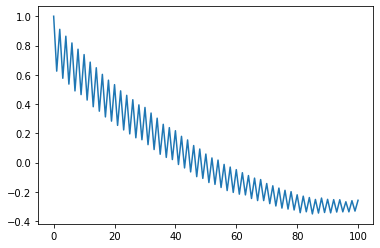

In [66]:
plt.plot(acf(data['KG'], nlags=100))

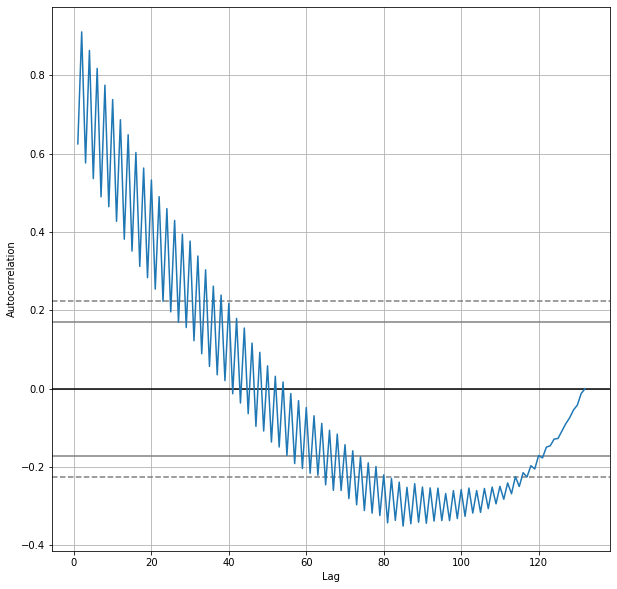

In [42]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pd.plotting.autocorrelation_plot(data['KG'], ax=ax)

In [44]:
def process_data(Xy, window=3, time_cols=12, remove_null=False):
  """
  This function splits your time series data into the proper windows

  Parameters
  ----------
  Xy: array
    The input data. If there are non-time series columns, assumes they are on
    the left and time columns are on the right. 
  time_cols: int
    The number of time columns, default 12
  window: int
    The time window size, default 3

  Returns
  -------
  X_: array
    The independent variables, includes time and non-time series columns with
    the new window
  y_: array
    The dependent variable, selected from the time columns at the end of the 
    window
  labels:
    The time series labels, can be used in subsequent plot
  """
  # separate the non-time series columns
  X_cat = Xy[:,:-time_cols]

  # select the columns to apply the sweeping window
  X = Xy[:,-time_cols:]

  X_ = []
  y = []

  for i in range(X.shape[1]-window):
    # after attaching the current window to the non-time series 
    # columns, add it to a growing list
    X_.append(np.concatenate((X_cat, X[:, i:i+window]), axis=1))

    # add the next time delta after the window to the list of y
    # values
    y.append(X[:, i+window])

  # X_ is 3D: [number of replicates from sweeping window,
  #           length of input data, 
  #           size of new feature with categories and time]
  # we want to reshape X_ so that the replicates due to the sweeping window is 
  # a part of the same dimension as the instances of the input data
  X_ = np.array(X_).reshape(X.shape[0]*np.array(X_).shape[0],window+X_cat.shape[1])
  y = np.array(y).reshape(X.shape[0]*np.array(y).shape[0],)

  if remove_null:
    # remove training data where the target is 0 (may be unfair advantage)
    X_ = X_[np.where(~np.isnan(y.astype(float)))[0]]
    y = y[np.where(~np.isnan(y.astype(float)))[0]]

  # create labels that show the previous month values used to train the model
  labels = []
  for row in X_:
    labels.append("X: {}".format(np.array2string(row[-window:].astype(float).round())))
  return X_, y, labels

In [85]:
Xy = orders.loc[[0], time_cols].values
# separate the non-time series columns
X_cat = Xy[:,:-120]

# select the columns to apply the sweeping window
X = Xy[:,-120:]

In [88]:
window_size = 1
X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)

<a name='x.3'></a>

## 6.3 Modeling

[back to top](#top)

In [68]:
from tensorflow import keras
from tensorflow.keras import layers

<a name='x.3.1'></a>

### 6.3.1 Models from Course 1 & 2

[back to top](#top)

<a name='x.3.2'></a>

### 6.3.2 Feed Forward Neural Network Model

[back to top](#top)

In [98]:
model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[window_size]),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

In [106]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
    monitor='loss'
)

In [107]:
history = model.fit(
    X, y,
    batch_size=10,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

In [135]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss
8,4293179.5
9,4291497.5
10,4253060.5
11,4256410.0
12,4237111.5


As we can see from the `y` vs `y_pred` the FFNN is just predicting the previous month's value:

In [136]:
y_pred = model.predict(X)
pd.DataFrame(y_pred, y)

,0
11569.168746,12571.741211
13616.812204,11570.894531
11884.370881,13617.884766
13950.332334,11885.996094
12781.156536,13951.298828
...,...
19384.824042,22326.982422
21449.154890,19384.060547
19554.405590,21447.728516
21873.104938,19553.585938


We can try this with a more suitable window size

In [179]:
window_size = 6
X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)

model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[window_size]),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

In [180]:
history = model.fit(
    X, y,
    batch_size=10,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

In [181]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss
368,295487.03125
369,308797.87500
370,298143.62500
371,293737.50000
372,290402.65625


A cursory glance looks like our values are closer together

In [182]:
y_pred = model.predict(X)
results = pd.DataFrame(y_pred, y)
results = results.reset_index()
results.index = data['Date'][window_size:]
results = results.reset_index()
results.columns=['Date', 'real', 'predicted']
results = results.melt(id_vars='Date', var_name='Source', value_name='KG')

In [183]:
px.line(results, x='Date', y='KG', color='Source')

### 6.3.3 Exercise: Vary model architecture and window size

### 6.3.4 LSTM NN

[back to top](#top)

Our data preparation for the LSTM NN includes time steps. The parameter `input_dim` tells our `LSTM` block how man time steps we have in the input data. This is a reframing (and a more appropriate reframing) of the same problem. The LSTM model is viewing the input feature w/ multiple time steps as a single feature at different times, rather than separate features. We could, for instance, have a second dimension that includes non-time related information, such as the customer name or truffle types.

In [265]:
window_size = 6
batch_size = 10
X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)
X = X.reshape(-1, 1, window_size)
y = y.reshape(-1, 1, 1)
model = keras.Sequential([
    layers.LSTM(8, activation='relu', input_dim=window_size),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

In [254]:
history = model.fit(
    X, y,
    batch_size=batch_size,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

In [255]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss
482,299145.84375
483,287835.28125
484,295304.37500
485,298131.43750
486,294824.31250


In [256]:
y_pred = model.predict(X)
results = pd.DataFrame(y_pred.flatten(), y.flatten())
results = results.reset_index()
results.index = data['Date'][window_size:]
results = results.reset_index()
results.columns=['Date', 'real', 'predicted']
results = results.melt(id_vars='Date', var_name='Source', value_name='KG')

In [257]:
px.line(results, x='Date', y='KG', color='Source')

### 6.3.5 LSTM with Memory Between Batches (Stateful LSTM)

In [307]:
window_size = 6
batch_size = 7 # needs to be a factor of X.shape[0]
features = 1
X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)
X = X.reshape(-1, window_size, features)
y = y.reshape(-1, 1, 1)
model = keras.Sequential([
    layers.LSTM(8, activation='relu', stateful=True, 
                batch_input_shape=(batch_size, window_size, features)),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

In [308]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (7, 8)                    320       
_________________________________________________________________
dense_56 (Dense)             (7, 1)                    9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [309]:
for i in range(100):
  model.fit(X, y,
            epochs=1, 
            batch_size=batch_size, 
            verbose=2, 
            shuffle=False)
  model.reset_states()

18/18 - 1s - loss: 561125824.0000
18/18 - 0s - loss: 515894336.0000
18/18 - 0s - loss: 493535872.0000
18/18 - 0s - loss: 474468800.0000
18/18 - 0s - loss: 457964288.0000
18/18 - 0s - loss: 443404192.0000
18/18 - 0s - loss: 430374016.0000
18/18 - 0s - loss: 418582624.0000
18/18 - 0s - loss: 407810432.0000
18/18 - 0s - loss: 397882688.0000
18/18 - 0s - loss: 388654336.0000
18/18 - 0s - loss: 380001056.0000
18/18 - 0s - loss: 371813472.0000
18/18 - 0s - loss: 363993248.0000
18/18 - 0s - loss: 356450272.0000
18/18 - 0s - loss: 349093248.0000
18/18 - 0s - loss: 342061984.0000
18/18 - 0s - loss: 336252064.0000
18/18 - 0s - loss: 358619200.0000
18/18 - 0s - loss: 354244736.0000
18/18 - 0s - loss: 349976608.0000
18/18 - 0s - loss: 345977536.0000
18/18 - 0s - loss: 342225760.0000
18/18 - 0s - loss: 338675552.0000
18/18 - 0s - loss: 335281216.0000
18/18 - 0s - loss: 331998976.0000
18/18 - 0s - loss: 328915008.0000
18/18 - 0s - loss: 328198464.0000
18/18 - 0s - loss: 328197920.0000
18/18 - 0s - l

In [310]:
y_pred = model.predict(X)
results = pd.DataFrame(y_pred.flatten(), y.flatten())
results = results.reset_index()
results.index = data['Date'][window_size:]
results = results.reset_index()
results.columns=['Date', 'real', 'predicted']
results = results.melt(id_vars='Date', var_name='Source', value_name='KG')
px.line(results, x='Date', y='KG', color='Source')

InvalidArgumentError: ignored

<a name='x.4'></a>

## 6.4 Model Results with Dash

[back to top](#top)